# Appendix B - Jupyter Code

##### Code and data files may also be found at https://github.com/shenwalter/EPS231

In [1]:
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import warnings;warnings.filterwarnings('ignore')
import numpy as np
import scipy as sp
import netCDF4
import pandas as pd

## SSP Projections of CO2 Concentration

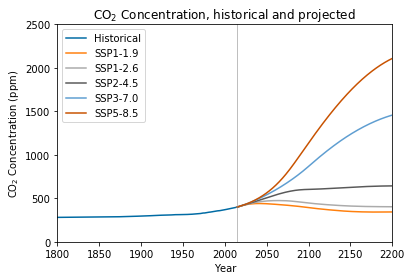

In [2]:
df_historical = pd.read_csv('SSP_data/historical.csv')
df_SSP119 = pd.read_csv('SSP_data/SSP119.csv')
df_SSP126 = pd.read_csv('SSP_data/SSP126.csv')
df_SSP245 = pd.read_csv('SSP_data/SSP245.csv')
df_SSP370 = pd.read_csv('SSP_data/SSP370.csv')
df_SSP585 = pd.read_csv('SSP_data/SSP585.csv')

#plt.figure(figsize=(15,7));

plt.plot(df_historical['year'],df_historical['data_mean_global'],label="Historical");
plt.plot(df_SSP119['year'],df_SSP119['data_mean_global'],label="SSP1-1.9");
plt.plot(df_SSP126['year'],df_SSP126['data_mean_global'],label="SSP1-2.6");
plt.plot(df_SSP245['year'],df_SSP245['data_mean_global'],label="SSP2-4.5");
plt.plot(df_SSP370['year'],df_SSP370['data_mean_global'],label="SSP3-7.0");
plt.plot(df_SSP585['year'],df_SSP585['data_mean_global'],label="SSP5-8.5");

plt.axvline(x=2015, color = 'gray', linewidth=.5);
plt.xlim([1800,2200]);
plt.ylim([0,2500])
plt.xlabel("Year")
plt.ylabel(f"CO$_2$ Concentration (ppm)")
plt.title(f"CO$_2$ Concentration, historical and projected");
plt.legend();

plt.savefig('fig1.png')

## Emissivity as function of CO2 Concentration

We allow tropospheric emissivity to follow the formulation in Salazar and Tziperman (2023):
$$
\epsilon_i=\epsilon_{i o}+A \log _2\left(\frac{\mathrm{CO}_2}{280}\right)+B \log _2\left(\frac{q_i}{q_{i o}}\right)
$$

In [3]:
eps_io = 0.5 # minimum free troposphere emissivity
A = 0.05 # sensitivity to CO2
B = 0.1 # climate sensitivitiy to H2O

RH_a = 0.4 # RH of troposphere
RH_s = 0.85 # relative humidity of surface

P_a = 600 # mb, medium height convection altitude
P_s = 1000 # mb, surface pressure
T_a_0 = 290 #K, initialized (present) atm temp
T_s_0 = 240 #K, initialized (present) surface temp

In [4]:
"""
Created on Thu Apr  6 15:31:21 2023
@author: Camille Hankel
"""
R_gas = 287 #J/kgK
R_v = 461 #gas constant for moist air J/(kg*K)
def q_s(T,P):
    # saturation specific humidity (gr water vapor per gram moist air):
    # inputs:
    # T: temperature, in Kelvin
    # P: pressure, in mb

    TT = T-273.15 # Kelvin to Celsius
    # Saturation water vapor pressure (mb) from Emanuel 4.4.14 p 116-117: 
    ew = 6.112*np.exp((17.67 * TT) / (TT + 243.5))
    # saturation mixing ratio (gr water vapor per gram dry air):
    rw = (R_gas/ R_v) * ew / (P - ew)
    # saturation specific humidity (gr water vapor per gram moist air):
    qw = rw / (1 + rw)
    
    return qw

In [5]:
def eps_CO2(A, B, CO2, T_s, T_a, P_s, P_a):
    # Input: CO2, ppm
    # Output: tropospheric emissivity
    q_io = RH_s * q_s(T_s, P_s) # surface specific humidity
    q_i = RH_a * q_s(T_a, P_a) # specific humidity just above the cloud layer
    return eps_io + A*np.log2(CO2/280) + B*np.log2(q_i/q_io)

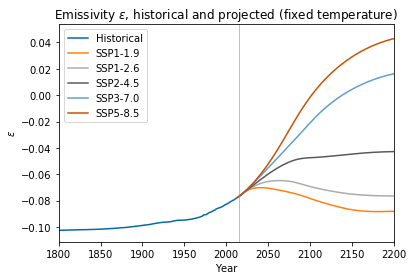

In [6]:
CO2_time_series = df_SSP585['data_mean_global']

plt.plot(df_historical['year'], eps_CO2(A,B,df_historical['data_mean_global'], T_a_0, T_s_0, P_s, P_a),label="Historical");
plt.plot(df_SSP119['year'], eps_CO2(A,B,df_SSP119['data_mean_global'], T_a_0, T_s_0, P_s, P_a),label="SSP1-1.9");
plt.plot(df_SSP126['year'], eps_CO2(A,B,df_SSP126['data_mean_global'], T_a_0, T_s_0, P_s, P_a),label="SSP1-2.6");
plt.plot(df_SSP245['year'], eps_CO2(A,B,df_SSP245['data_mean_global'], T_a_0, T_s_0, P_s, P_a),label="SSP2-4.5");
plt.plot(df_SSP370['year'], eps_CO2(A,B,df_SSP370['data_mean_global'], T_a_0, T_s_0, P_s, P_a),label="SSP3-7.0");
plt.plot(df_SSP585['year'], eps_CO2(A,B,df_SSP585['data_mean_global'], T_a_0, T_s_0, P_s, P_a),label="SSP5-8.5");

plt.axvline(x=2015, color = 'gray', linewidth=.5);
plt.xlim([1800,2200]);
plt.xlabel("Year")
plt.ylabel(f"$\epsilon$")
plt.title(f"Emissivity $\epsilon$, historical and projected (fixed temperature)");
plt.legend();

plt.savefig('fig2.png')

## Numerical Simulation

In [7]:
# Constants
F_s = 250 #W/m^2
F_a = 100 #W/m^2
P_a = 600 # mb, medium height convection altitude
P_s = 1000 # mb, surface pressure
sigma = 5.67e-8 # Stefan–Boltzmann constant, J s-1 m-2 K-4
C_p = 1000 # J K-1 kg-1, Specific heat of dry air, constant pressure
L = 2.25e6 # J kg-1 , latent heat of evaporation
H = 8000 # scale height in m
z_a = -np.log(P_a/(1000))*H # using scale height of 8km
g = 9.81 # gravity constant, m/s^2

The equations of the two-layer radiative-convective model from Abbot and Tziperman (2009):
$$
\begin{equation}
\begin{aligned}
C_s \frac{dT_s}{dt} &= F_s - F_c + {\epsilon}\sigma T^4_a - \sigma T^4_s\\
C_a \frac{dT_a}{dt} &= F_a + F_c + {\epsilon}\sigma (T^4_s - 2 T^4_a)
\end{aligned}
\end{equation}
$$

In [8]:
C_s = C_p/2 # total heat capacity of surface column
C_a = C_p/2 # THC of atmosphere column
F_c = 50 # convective heat flux fixed to be positive

In [9]:
def dT_sdt(CO2, T_s, T_a, P_s, P_a):
    return (F_s - F_c + eps_CO2(A,B, CO2, T_s, T_a, P_s, P_a)*sigma*T_a**4 - sigma*T_s**4)/C_s

def dT_adt(CO2, T_s, T_a, P_s, P_a):
    return (F_a + F_c + eps_CO2(A,B, CO2, T_s, T_a, P_s, P_a)*sigma*(T_s**4 - 2*sigma*T_a**4))/C_a

In [10]:
def solve_T_s(T_s_0, T_a_0, df):
    # Solves the pde system 
    dt = 1#365*24*3600
    t = df['year']
    CO2_time_series = df['data_mean_global']
    
    T_s_series = np.zeros(len(t))
    T_a_series = np.zeros(len(t))
    T_s_series[0] = T_s_0
    T_a_series[0] = T_a_0
    for i in range(1, len(t)):
        T_s = T_s_series[i-1]
        T_a = T_a_series[i-1]
        CO2 = CO2_time_series[i]
        T_s_series[i] = T_s_series[i-1] + dt * dT_sdt(CO2, T_s, T_a, P_s, P_a)
        T_a_series[i] = T_a_series[i-1] + dt * dT_adt(CO2, T_s, T_a, P_s, P_a)
    return T_s_series, T_a_series

In [11]:
T_s_0=290
T_a_0=240

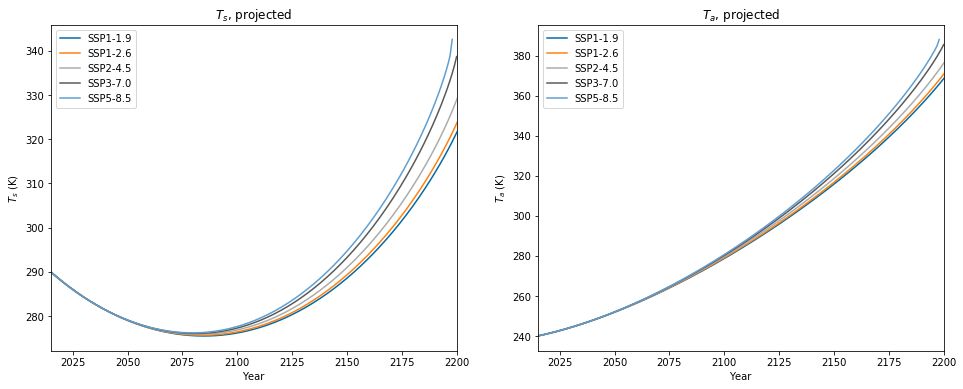

In [12]:
plt.figure(figsize=(16,6)); plt.clf();

plt.subplot(1,2,1);
#plt.plot(df_historical['year'], solve_T_s(T_s_0, T_a_0, df_historical)[0],label="Historical");
plt.plot(df_SSP119['year'],solve_T_s(T_s_0, T_a_0, df_SSP119)[0],label="SSP1-1.9");
plt.plot(df_SSP126['year'],solve_T_s(T_s_0, T_a_0, df_SSP126)[0],label="SSP1-2.6");
plt.plot(df_SSP245['year'],solve_T_s(T_s_0, T_a_0, df_SSP245)[0],label="SSP2-4.5");
plt.plot(df_SSP370['year'],solve_T_s(T_s_0, T_a_0, df_SSP370)[0],label="SSP3-7.0");
plt.plot(df_SSP585['year'],solve_T_s(T_s_0, T_a_0, df_SSP585)[0],label="SSP5-8.5");

plt.xlim([2015,2200]);
#plt.ylim([273,300])
plt.xlabel("Year")
plt.ylabel(f"$T_s$ (K)")
plt.title(f"$T_s$, projected");
plt.legend();


plt.subplot(1,2,2);
#plt.plot(df_historical['year'], solve_T_s(T_s_0, T_a_0, df_historical)[0],label="Historical");
plt.plot(df_SSP119['year'],solve_T_s(T_s_0, T_a_0, df_SSP119)[1],label="SSP1-1.9");
plt.plot(df_SSP126['year'],solve_T_s(T_s_0, T_a_0, df_SSP126)[1],label="SSP1-2.6");
plt.plot(df_SSP245['year'],solve_T_s(T_s_0, T_a_0, df_SSP245)[1],label="SSP2-4.5");
plt.plot(df_SSP370['year'],solve_T_s(T_s_0, T_a_0, df_SSP370)[1],label="SSP3-7.0");
plt.plot(df_SSP585['year'],solve_T_s(T_s_0, T_a_0, df_SSP585)[1],label="SSP5-8.5");

plt.xlim([2015,2200]);
#plt.ylim([240,325])
plt.xlabel("Year")
plt.ylabel(f"$T_a$ (K)")
plt.title(f"$T_a$, projected");
plt.legend();

plt.savefig('fig3.png')